In [1]:
import pandas as pd
import eurostat

In [2]:
df = eurostat.get_data_df(code="HBS_STR_T223")
df = df.rename(columns={'geo\TIME_PERIOD': 'geo', '2015':'OBS_VALUE'})


In [3]:
unique_values_df1 = df["geo"].unique()

In [4]:
# Keep only the rows where TIME_PERIOD is equal to 2015
df = df.loc[:, ['quantile','coicop','geo','OBS_VALUE']]


In [5]:
df_inflation = eurostat.get_data_df(code="PRC_HICP_MANR",filter_pars={'startPeriod':"2021-03"})
df_inflation = df_inflation.rename(columns={'geo\TIME_PERIOD': 'geo'})


In [6]:
merged_df = df.merge(df_inflation, on=["coicop", "geo"])


In [7]:
merged_df.columns

Index(['quantile', 'coicop', 'geo', 'OBS_VALUE', 'freq', 'unit', '2021-03',
       '2021-04', '2021-05', '2021-06', '2021-07', '2021-08', '2021-09',
       '2021-10', '2021-11', '2021-12', '2022-01', '2022-02', '2022-03',
       '2022-04', '2022-05', '2022-06', '2022-07', '2022-08', '2022-09',
       '2022-10', '2022-11', '2022-12', '2023-01', '2023-02', '2023-03',
       '2023-04'],
      dtype='object')

In [8]:
cols_to_multiply = [col for col in merged_df.columns if col.startswith('202')]
merged_df[['w' + col for col in cols_to_multiply]] = merged_df[cols_to_multiply].apply(lambda x: x * merged_df['OBS_VALUE']/1000)


In [9]:
merged_df_5_chars = merged_df[merged_df['coicop'].str.len() == 5]


In [10]:
columns_to_sum = [col for col in merged_df_5_chars.columns if col.startswith('w')]
                  
summed_columns = []
for col in columns_to_sum:
    new_col_name = col[1:]
    summed_columns.append(new_col_name)
    merged_df_5_chars[new_col_name] = merged_df_5_chars.groupby(['geo', 'quantile'])[col].transform('sum')

df_inflation_by_quintile = merged_df_5_chars[['geo', 'quantile'] + summed_columns].drop_duplicates()

C:\Users\maxen\AppData\Local\Temp\ipykernel_11080\899747291.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  merged_df_5_chars[new_col_name] = merged_df_5_chars.groupby(['geo', 'quantile'])[col].transform('sum')
C:\Users\maxen\AppData\Local\Temp\ipykernel_11080\899747291.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  merged_df_5_chars[new_col_name] = merged_df_5_chars.groupby(['geo', 'quantile'])[col].transform('sum')
C:\Users\maxen\AppData\Local\Temp\ipykernel_11080\899747291.py:7: SettingWithCopyW

In [11]:
# For EU27_2020, only the groups of coicop with 4 characters have value

merged_df_4_chars = merged_df[merged_df['coicop'].str.len() == 4]
merged_df_4_chars = merged_df_4_chars.loc[(merged_df_4_chars['geo'] == 'EU27_2020')]
summed_columns = []
for col in columns_to_sum:
    new_col_name = col[1:]
    summed_columns.append(new_col_name)
    merged_df_4_chars[new_col_name] = merged_df_4_chars.groupby(['geo', 'quantile'])[col].transform('sum')

df_inflation_by_quintile_eu27 = merged_df_4_chars[['geo', 'quantile'] + summed_columns].drop_duplicates()


In [12]:
df_inflation_by_quintile = pd.concat([df_inflation_by_quintile, df_inflation_by_quintile_eu27])

In [13]:
# we drop Italy and EA because they don't have the values, and TR because they have a crazy high inflation
df_inflation_by_quintile = df_inflation_by_quintile.loc[~df_inflation_by_quintile['geo'].isin(['IT', 'EA', 'TR'])]

In [14]:
df_inflation_by_quintile_2022_03 = df_inflation_by_quintile[["geo","quantile","2022-03"]]

In [15]:
df_inflation_by_quintile_2022_03 = df_inflation_by_quintile_2022_03.pivot(index="geo",columns="quantile",values="2022-03")

In [16]:
country_names = {
    'AT': 'Austria',
    'BE': 'Belgium',
    'BG': 'Bulgaria',
    'CY': 'Cyprus',
    'CZ': 'Czechia',
    'DE': 'Germany',
    'DK': 'Denmark',
    'EE': 'Estonia',
    'EL': 'Greece',
    'ES': 'Spain',
    'FI': 'Finland',
    'FR': 'France',
    'HR': 'Croatia',
    'HU': 'Hungary',
    'IE': 'Ireland',
    'LT': 'Lithuania',
    'LU': 'Luxembourg',
    'LV': 'Latvia',
    'MT': 'Malta',
    'NL': 'Netherlands',
    'NO': 'Norway',
    'PL': 'Poland',
    'PT': 'Portugal',
    'RO': 'Romania',
    'SE': 'Sweden',
    'SI': 'Slovenia',
    'SK': 'Slovakia',
    'ME': 'Montenegro',
    'MK': 'North Macedonia',
    'RS': 'Serbia',
    'XK': 'Kosovo',
    'EU27_2020' : 'European Union'
}
# df_inflation_by_quintile_2022_03 = df_inflation_by_quintile_2022_03.rename(index=country_names)

In [17]:
df_inflation_by_quintile_2022_03.sort_values('QUINTILE1')

quantile,QUINTILE1,QUINTILE2,QUINTILE3,QUINTILE4,QUINTILE5,UNK
geo,,,,,,
SE,3.7276,4.2835,4.5745,4.8378,4.6379,NaN
FR,3.7501,3.7689,3.7649,3.7306,3.6455,NaN
FI,3.8432,4.1689,4.3593,4.5392,4.8362,NaN
NO,4.1843,4.0578,4.3792,4.1970,4.4074,NaN
PT,4.3999,4.5944,4.7742,4.7819,4.8012,NaN
SI,4.6750,4.8841,5.4161,5.6616,6.0114,NaN
MT,4.8938,4.8600,4.6352,4.6686,4.6515,NaN
HU,5.5930,5.6872,5.9496,6.1537,6.4092,NaN
AT,5.8636,6.4280,6.6480,7.0177,7.0941,NaN


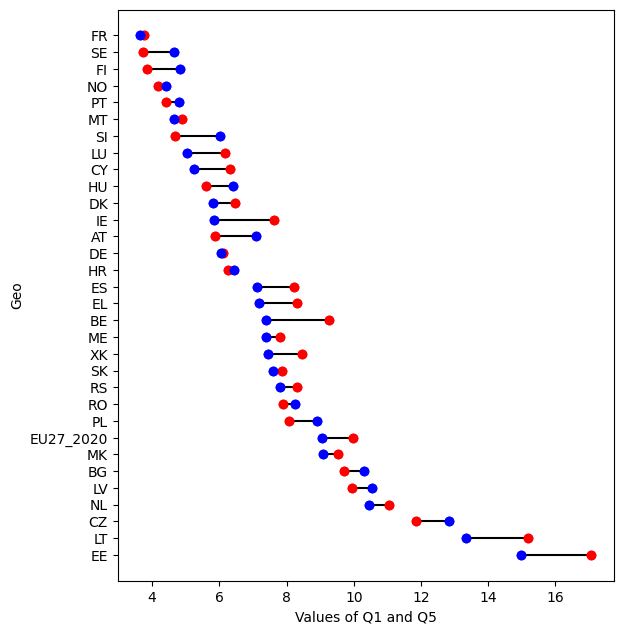

In [18]:
import matplotlib.pyplot as plt

df_inflation_by_quintile_2022_03['min'] = df_inflation_by_quintile_2022_03[['QUINTILE1','QUINTILE5']].min(axis=1)
df_inflation_by_quintile_2022_03 = df_inflation_by_quintile_2022_03.sort_values('min', ascending=False)
# Split the data into groups based on the "geo" column
groups = df_inflation_by_quintile_2022_03.groupby('geo', sort=False)
# Create a figure and axes for the plot
fig, ax = plt.subplots()

# Loop over each group of data
for name, group in groups:
    # Plot a point for the "Q1" column and a point for the "Q5" column
    ax.plot([group['QUINTILE1'], group['QUINTILE5']], [name, name], '-', color='black')
    ax.plot([group['QUINTILE1'], group['QUINTILE1']], [name, name], 'o', color='red')
    ax.plot([group['QUINTILE5'], group['QUINTILE5']], [name, name], 'o', color='blue')
    


# Add labels to the axes
ax.set_xlabel('Values of Q1 and Q5')
ax.set_ylabel('Geo')


# Adjust the spacing between the subplots
fig.subplots_adjust(top=1.3)

# Show the plot
plt.show()

In [27]:
df_inflation_by_quintile_2022_03['Q1/Q5'] = df_inflation_by_quintile_2022_03['QUINTILE1']/df_inflation_by_quintile_2022_03['QUINTILE5']

In [23]:
df_inflation_NRG = df_inflation[df_inflation["coicop"] == "NRG"]
df_inflation_NRG = df_inflation_NRG.loc[:, ['geo', '2022-03']]
df_inflation_NRG = df_inflation_NRG.rename(columns={'2022-03': 'NRG_inflation'})

In [24]:
df_inflation_by_quintile_2022_03 = df_inflation_by_quintile_2022_03.merge(df_inflation_NRG,on="geo")

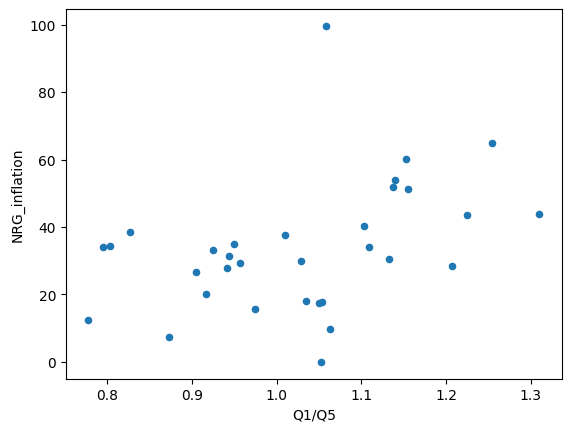

In [29]:
# Create a scatter plot with Q5/Q1 on the x-axis and NRG_inflation on the y-axis
df_inflation_by_quintile_2022_03.plot.scatter(x='Q1/Q5', y='NRG_inflation')

# Add labels to the axes
plt.xlabel('Q1/Q5')
plt.ylabel('NRG_inflation')

# Show the plot
plt.show()

In [30]:
df_inflation_by_quintile_2022_03['Q1/Q5'].corr(df_inflation_by_quintile_2022_03['NRG_inflation'])

0.3983325313500468

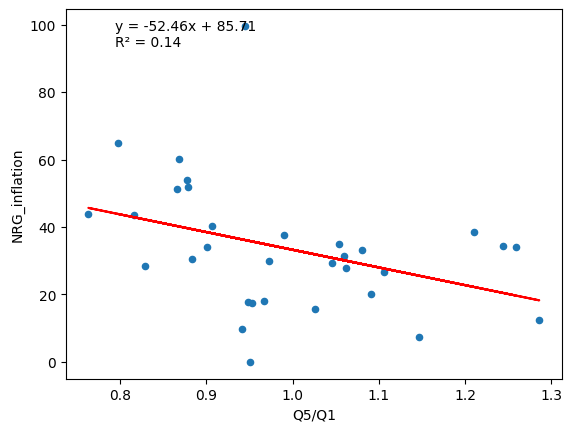

In [31]:
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import linregress


# Calculate Q5/Q1 and add it as a new column to the DataFrame
df_inflation_by_quintile_2022_03['Q5/Q1'] = df_inflation_by_quintile_2022_03['QUINTILE5'] / df_inflation_by_quintile_2022_03['QUINTILE1']

# Perform linear regression between Q5/Q1 and NRG_inflation
slope, intercept, r_value, p_value, std_err = linregress(df_inflation_by_quintile_2022_03['Q5/Q1'], df_inflation_by_quintile_2022_03['NRG_inflation'])

# Create a scatter plot with Q5/Q1 on the x-axis and NRG_inflation on the y-axis
df_inflation_by_quintile_2022_03.plot.scatter(x='Q5/Q1', y='NRG_inflation')

# Add the regression line to the plot
plt.plot(df_inflation_by_quintile_2022_03['Q5/Q1'], slope * df_inflation_by_quintile_2022_03['Q5/Q1'] + intercept, color='red')

# Add labels to the axes
plt.xlabel('Q5/Q1')
plt.ylabel('NRG_inflation')

# Add the regression equation to the plot
plt.annotate(f'y = {slope:.2f}x + {intercept:.2f}\nR² = {r_value ** 2:.2f}', xy=(0.1, 0.9), xycoords='axes fraction')

# Show the plot
plt.show()


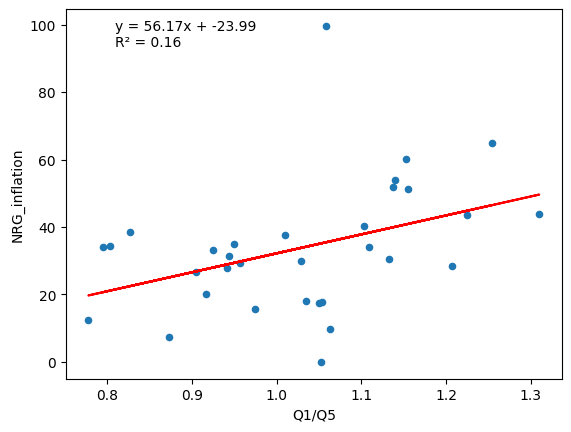

In [32]:
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import linregress


# Calculate Q1/Q5 and add it as a new column to the DataFrame
df_inflation_by_quintile_2022_03['Q1/Q5'] = df_inflation_by_quintile_2022_03['QUINTILE1'] / df_inflation_by_quintile_2022_03['QUINTILE5']

# Perform linear regression between Q1/Q5 and NRG_inflation
slope, intercept, r_value, p_value, std_err = linregress(df_inflation_by_quintile_2022_03['Q1/Q5'], df_inflation_by_quintile_2022_03['NRG_inflation'])

# Create a scatter plot with Q1/Q5 on the x-axis and NRG_inflation on the y-axis
df_inflation_by_quintile_2022_03.plot.scatter(x='Q1/Q5', y='NRG_inflation')

# Add the regression line to the plot
plt.plot(df_inflation_by_quintile_2022_03['Q1/Q5'], slope * df_inflation_by_quintile_2022_03['Q1/Q5'] + intercept, color='red')

# Add labels to the axes
plt.xlabel('Q1/Q5')
plt.ylabel('NRG_inflation')

# Add the regression equation to the plot
plt.annotate(f'y = {slope:.2f}x + {intercept:.2f}\nR² = {r_value ** 2:.2f}', xy=(0.1, 0.9), xycoords='axes fraction')

# Show the plot
plt.show()


C:\Users\maxen\AppData\Local\Temp\ipykernel_11080\1681162680.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_inflation_by_quintile_2022_03['Q1/Q5'] = df_inflation_by_quintile_2022_03['QUINTILE1'] / df_inflation_by_quintile_2022_03['QUINTILE5']


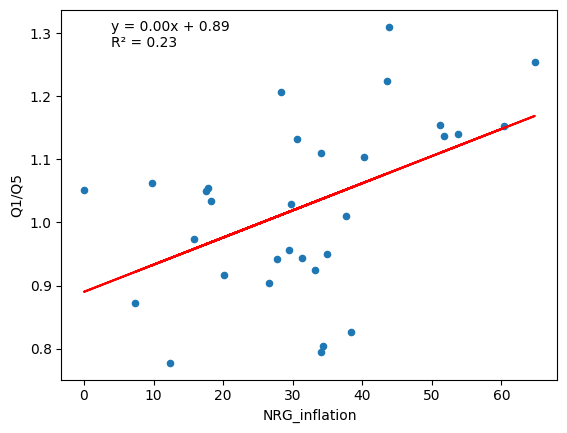

In [36]:
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import linregress


# Calculate Q1/Q5 and add it as a new column to the DataFrame
df_inflation_by_quintile_2022_03['Q1/Q5'] = df_inflation_by_quintile_2022_03['QUINTILE1'] / df_inflation_by_quintile_2022_03['QUINTILE5']

# Perform linear regression between NRG_inflation and Q1/Q5
slope, intercept, r_value, p_value, std_err = linregress(df_inflation_by_quintile_2022_03['NRG_inflation'], df_inflation_by_quintile_2022_03['Q1/Q5'])

# Create a scatter plot with NRG_inflation on the x-axis and Q1/Q5 on the y-axis
df_inflation_by_quintile_2022_03.plot.scatter(x='NRG_inflation', y='Q1/Q5')

# Add the regression line to the plot
plt.plot(df_inflation_by_quintile_2022_03['NRG_inflation'], slope * df_inflation_by_quintile_2022_03['NRG_inflation'] + intercept, color='red')

# Add labels to the axes
plt.xlabel('NRG_inflation')
plt.ylabel('Q1/Q5')

# Add the regression equation to the plot
plt.annotate(f'y = {slope:.2f}x + {intercept:.2f}\nR² = {r_value ** 2:.2f}', xy=(0.1, 0.9), xycoords='axes fraction')

# Show the plot
plt.show()


voir indice de Gini